In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
T = 1

# Forward simulation of the $W_{t_i}$

$\{W_t\}$ is a standard brownian motion process. Thus, it holds that the increments
$$
    W_{t^n_i} - W_{t^n_{i-1}},\ i\in\{1,\ldots,2^n\}
$$
is a family of independent $\mathcal N(0,\Delta T)$ random variables. Setting
$$
    Z_i = \frac{1}{\sqrt{\Delta T}}\left(W_{t^n_i} - W_{t^n_{i-1}}\right)
$$
ensures the $Z_i$ are iid $\mathcal N(0, 1)$ variables satisfying
$$
    W_{t^n_i} = W_{t_{i-1}^n} + \sqrt{\Delta T}Z_i.
$$

In [77]:
def brownian(n, T, shape=None):
    """
    Simulate a set trajectories of the standard brownian motion on the dyadic
    mesh t_i = T*k/2^n.
    n (int): log2-size of the mesh
    T (float): time horizon
    shape (tuple[int]): shape of the set of brownian motions we want
    """
    dt = T*2**(-n)
    if isinstance(shape, tuple):
        zi = np.random.randn(2**n, *shape)
    else:
        zi = np.random.randn(2**n)
    zi = np.sqrt(dt)*zi
    res = np.cumsum(zi, axis=0)
    return res

(512, 1000)


Text(0.5,1,'Time-forward simulation of standard brownian motion')

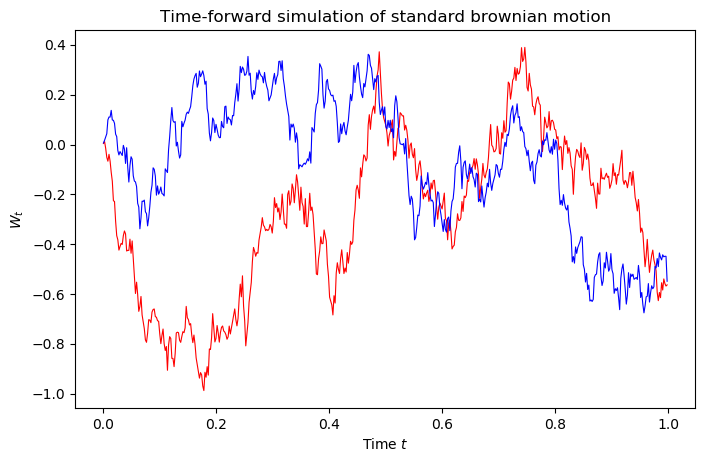

In [78]:
n = 9
plt.figure(figsize=(8,5), dpi=100)
tin = np.arange(0, T, 2**(-n))
samples = brownian(n, T, (1000,))
print(samples.shape)
plt.plot(tin, samples[:,0], 'r-', linewidth=0.8)
plt.plot(tin, samples[:,1], 'b-', linewidth=0.8)
plt.xlabel("Time $t$")
plt.ylabel("$W_t$")
plt.title("Time-forward simulation of standard brownian motion")

In [75]:
samples[0].shape

(1000,)

In [7]:
from ipywidgets import widgets, interact
from IPython import display

In theory,
$$
\begin{aligned}
    \mathbb E[W_T] &= 0 \\
    \mathrm{Var}[W_T] &= T \\
    \mathrm{Cov}(W_T, W_{T/2}) &= \mathrm{Cov}(W_T-W_{T/2}+W_{T/2}, W_{T/2}) = \mathrm{Cov}(W_{T/2}, W_{T/2}) = T/2
\end{aligned}
$$

In [95]:
Nmin = 5
Nmax = 17
mu_vals = []
sigma_vals = []
cov_vals = []

for n in range(Nmin, Nmax):
    print("Number of samples: %s" % 2**n)
    samples = brownian(n, T, (1000,))

    mu = np.mean(samples[-1])
    mu_vals.append(mu)
    print("Mean: %s" % mu)

    sigma2 = np.var(samples[-1], ddof=1)
    sigma_vals.append(sigma2)
    print("Variance: %s" % sigma2)

    covar = np.cov(samples[-1], samples[2**(n-1)])
    cov_vals.append(covar[0,1])
    print("Covariance of (WT, WT/2): %s" % covar[0,1])
    print()


Number of samples: 32
Mean: -0.051429920351860135
Variance: 1.0083649486395703
Covariance of (WT, WT/2): 0.5327412679006722

Number of samples: 64
Mean: 0.012504276514343583
Variance: 0.9563821278443185
Covariance of (WT, WT/2): 0.5111121095365597

Number of samples: 128
Mean: 0.006312052494784979
Variance: 1.013196019433405
Covariance of (WT, WT/2): 0.5026287225996305

Number of samples: 256
Mean: -0.05745763631153389
Variance: 0.9644588442500898
Covariance of (WT, WT/2): 0.4714408120509028

Number of samples: 512
Mean: 0.02023929357626995
Variance: 1.0682005759596256
Covariance of (WT, WT/2): 0.5252488541955109

Number of samples: 1024
Mean: -0.042410205688985556
Variance: 0.980619427978178
Covariance of (WT, WT/2): 0.4668153493720661

Number of samples: 2048
Mean: -0.06775636199377771
Variance: 1.0156912479204583
Covariance of (WT, WT/2): 0.5006018323254324

Number of samples: 4096
Mean: 0.0042352818253945735
Variance: 0.9536132128726477
Covariance of (WT, WT/2): 0.47129710197500924

Text(0.5,0,'Log2-sample size $n$')

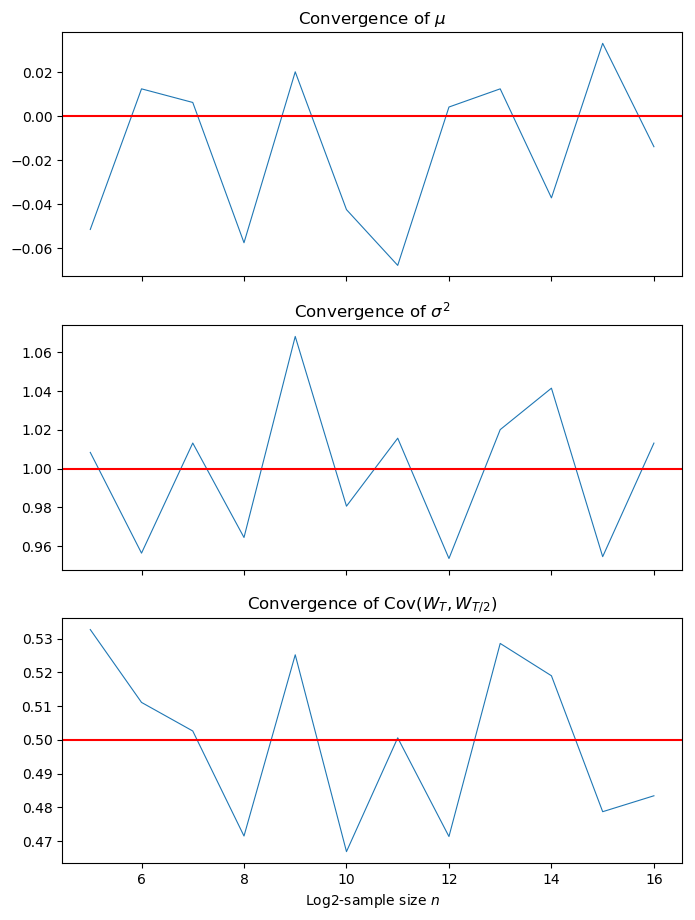

In [100]:
fig, axes = plt.subplots(3, 1, figsize=(8,11), dpi=100, sharex=True)

my_style = {
    'linewidth': 0.8
}

n_sizes = range(Nmin, Nmax)
axes[0].plot(n_sizes, mu_vals, **my_style)
axes[0].axhline(0, 0, T, color='r')
axes[0].set_title(r"Convergence of $\mu$")

axes[1].plot(n_sizes, sigma_vals, **my_style)
axes[1].axhline(T, 0, T, color='r')
axes[1].set_title(r"Convergence of $\sigma^2$")

axes[2].plot(n_sizes, cov_vals, **my_style)
axes[2].axhline(T/2, 0, T, color='r')
axes[2].set_title(r"Convergence of $\mathrm{Cov}(W_T, W_{T/2})$")
axes[2].set_xlabel("Log2-sample size $n$")

# Backward simulation

We compute the characteristic function of $W_{\bar s}\,|\, (W_{s_1}=x_1, W_{s_2}=x_2)$:
$$
\begin{aligned}
    \mathbb E\left[ e^{iuW_{\bar s}} \middle| W_{s_1}=x_1, W_{s_2}=x_2 \right]
    &=
    e^{iu\bar x}\mathbb E\left[ \exp\left(iu \left(W_{\bar s}-\frac{W_{s_1} + W_{s_2}}{2}\right)\right) \middle| W_{s_1}=x_1, W_{s_2}=x_2 \right]  \\
    &= e^{iu\bar x} \mathbb E\left[\mathbb E_{W_{s_1}=x_1} \left[e^{iu \left(W_{\bar s}-\frac{W_{s_1} + W_{s_2}}{2}\right)} \right] \middle| W_{s_1}=x_1, W_{s_2}=x_2 \right] \ \text{(Conditional expectation)} \\
    &= e^{iu\bar x}\mathbb E\left[ \mathbb E_{W_{s_1}=x_1} \left[e^{iu \left(W_{\bar s}-W_{s_1}\right)/2} \right] e^{iu(W_{\bar s}-W_{s_2})/2} \middle| W_{s_1}=x_1, W_{s_2}=x_2\right]\ \text{(Independence of increments)} \\
    &= e^{iu\bar x}\mathbb E\left[ e^{-\frac12u^2\frac{\bar s - s_1}{4}}e^{iu(W_{\bar s}-W_{s_2})/2} \middle| W_{s_1}=x_1, W_{s_2}=x_2 \right] \\
    &= \exp\left(iu\bar x - \frac 12 u^2\frac14\left(\bar s - s_1 + (s_2-\bar s) \right) \right) \\
    &= \exp\left(iu\bar x - \frac 12 u^2\frac{s_2 - s_1}4\right)
\end{aligned}
$$

Thus, the variable has conditional distribution $\mathcal N(\bar x, \frac{s_2-s_1}{4})$.

The same can be said of $W_{\bar s}\,|\, (W_{s_1}=x_1, W_{s_2}=x_2, (W_u)_{u\not\in[s_1,s_2]})$, as the same computation as above will work.